# Entrega Final do Projeto [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SimpleANPR/anpr/blob/main/Entrega_Final.ipynb)

Esse Jupyter Notebook contém os resultados finais do projeto, apresentando um comparativo das abordagens selecionadas. 

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    # Configurando o ambiente para execução no colab
    !git clone https://github.com/SimpleANPR/anpr
    %cd /content/anpr
    %pip install -r requirements.txt

## Dataset

O dataset selecionado foi o conjunto de imagens de benchmark utilizados pelo OpenALPR (https://github.com/openalpr/benchmarks). Ao todo, temos um total de 444 imagens anotados de veículos e suas placas.

In [3]:
from anpr.datasets.open_alpr import OpenALPRDataset
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import plotly.express as px

In [4]:
# Acessando o dataset (realiza o download automático das imagens)
ds = OpenALPRDataset()
print(f'Quantidade total de imagens: {ds.total_images()}')

Quantidade total de imagens: 444


In [5]:
def show_image_with_plate(img):
    """Método utilitário que mostra uma
    imagem anotada do dataset OpenALPR.

    Args:
        img (OpenALPRImage): imagem anotada.
    """
    print(f'Placa: {img.plate_text}')
    _, ax = plt.subplots()
    ax.imshow(img.image)
    x, y, w, h = img.plate_rect
    ax.add_patch(patches.Rectangle((x, y), w, h, 
                                linewidth=1, 
                                edgecolor='r', 
                                facecolor='none'))

Placa: PUT6858


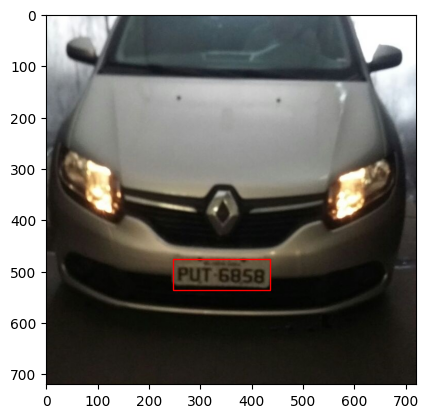

In [6]:
# Exemplo de uma imagem anotada do dataset
img = ds.image_at(120)
show_image_with_plate(img)

In [7]:
# Coletando medidas estatísticas do dataset
data = {
    'resolution': [],
    'plate_area': []
}

for i in range(ds.total_images()):
    annotated_img = ds.image_at(i)
    h, w, _ = annotated_img.image.shape
    _, _, p_w, p_h = annotated_img.plate_rect

    # Adicionando essa resolução
    target_res = f'{w}x{h}'
    data['resolution'].append(target_res)

    # Adicionando área normalizada
    image_area = h * w
    plate_area = p_w * p_h
    norm_area = plate_area / image_area
    data['plate_area'].append(round(norm_area * 100, 2))

In [8]:
# Histograma das resoluções do dataset
df = pd.DataFrame({'resolution': data['resolution']})
df = df.sort_values(by='resolution')
px.histogram(df, x='resolution')

# Da figura, conseguimos perceber que existe uma quantidade
#   variada de resoluções no dataset. Todavia, muitas imagens
#   possuem resolução 1280x720.

In [9]:
# Distribuição das áreas dos retângulos das placas
df = pd.DataFrame({'plate_area': data['plate_area']})
px.histogram(df, x='plate_area', nbins=20)

# A figura indica a % da área ocupada pela placa com relação
#   à área total da imagem. Conseguimos perceber que a grande maioria
#   das placas ocupa <5% da área total da imagem, todavia
#   existem algumas imagem onde a placa ocupa >15% da área
#   total.

# SimpleANPR: Uma abordagem simplificada para Reconhecimento de Placas Veiculares

Essa seção contém um comparativo de 3 abordagens para ANPR utilizando o framework proposto. Especificamente, testamos 3 formas de detecção de placas diferentes: (i) baseada em Bordas; (ii) baseada em Cor/Textura; (iii) baseada em Classificadores.

![](.github/img/simple-anpr.jpg)


In [10]:
# ==== Imports ====
import json

import numpy as np
import pandas as pd
import shapely

from anpr.binarization.adaptative_gaussian import AdaptativeGaussianBinarizer
from anpr.binarization.adaptative_mean import AdaptativeMeanBinarizer
from anpr.binarization.kittler import KittlerBinarizer
from anpr.binarization.otsu import OtsuBinarizer
from anpr.core.binarizer import Binarizer
from anpr.core.image_processor import ImageProcessor
from anpr.core.plate_detector import DetectionResult, PlateDetector
from anpr.datasets.open_alpr import OpenALPRDataset, OpenALPRImage
from anpr.detection.estimator_detector import EstimatorDetector
from anpr.generic.brightness import Brightness
from anpr.generic.contrast import Contrast
from anpr.generic.filter_bilateral import FilterBilateral
from anpr.generic.filter_gaussian import FilterGaussian
from anpr.generic.filter_mean import FilterMean
from anpr.generic.filter_median import FilterMedian
from anpr.generic.filter_nlm import FilterNLM
from anpr.generic.grayscale import GrayScale
from anpr.generic.histogram_normalization import HistogramNormalization
from anpr.generic.morphological_closing import MorphologicalClosing
from anpr.generic.morphological_opening import MorphologicalOpening
from anpr.generic.negative import Negative
from anpr.ocr.easy_ocr import EasyOCR

rng = np.random.default_rng(42)

In [11]:
# ==== Definição de funções/classes utilitárias ====

import numpy as np


from anpr.core.plate_detector import DetectionResult


class AggregateProcessor(ImageProcessor):
    """Agregador de etapas de processamento
    sequencial. Aplica cada um dos processamentos
    de forma sequencial (i.e., saída de um é entrada
    para o próximo).
    """

    def __init__(self, processors: list[ImageProcessor]) -> None:
        self._processors = processors

    def process(self, image: np.ndarray) -> np.ndarray:
        for p in self._processors:
            image = p.process(image)

        return image


class DetectorWithProcessing(PlateDetector):
    def __init__(self,
                 detector: PlateDetector,
                 processor: ImageProcessor,
                 apply_processor_in_detect: bool = False):
        self._detector = detector
        self._processor = processor
        self._apply = apply_processor_in_detect

    @property
    def detector(self) -> PlateDetector:
        return self._detector

    @property
    def processor(self) -> ImageProcessor:
        return self._processor

    def detect(self, image: np.ndarray) -> DetectionResult:
        if self._apply:
            image = self.processor.process(image)

        return self._detector.detect(image)


def calculate_metrics(detector: PlateDetector,
                      ds: OpenALPRDataset,
                      preprocessing_ocr: ImageProcessor = None,
                      correct_overlap_th: float = 0.5) -> dict:
    # TODO: adicionar métricas do OCR
    metrics = {
        'Imagens Segmentadas': 0,
        'Imagens não Segmentadas': 0,
        'Acertos Detecção': 0,
        'Erros Detecção': 0,
    }
    ocr = EasyOCR()

    def _correct_plate(true, pred):
        true_rect = shapely.box(xmin=true[0], xmax=true[0] + true[2],
                                ymin=true[1], ymax=true[1] + true[3])
        pred_rect = shapely.box(xmin=pred[0], xmax=pred[0] + pred[2],
                                ymin=pred[1], ymax=pred[1] + pred[3])

        if not pred_rect.intersects(true_rect):
            return False

        int_area = shapely.intersection(true_rect, pred_rect).area
        return int_area >= correct_overlap_th * true_rect.area

    for i in range(ds.total_images()):
        ds_img = ds.image_at(i)
        detection = detector.detect(ds_img.image)

        if detection.found_plate:
            metrics['Imagens Segmentadas'] += 1
            if _correct_plate(ds_img.plate_rect,
                              detection.plate_polygon):
                metrics['Acertos Detecção'] += 1
            else:
                metrics['Erros Detecção'] += 1
        else:
            metrics['Imagens não Segmentadas'] += 1

        # TODO: adicionar avaliação do OCR

    return metrics


def show_detection(detector: DetectorWithProcessing,
                   ds: OpenALPRDataset,
                   image_idx: int,
                   color_true: str = 'g',
                   color_candidate: str = 'b',
                   color_selected: str = 'r',
                   cmap_processed=None):
    ds_img = ds.image_at(image_idx)
    detection = detector.detect(ds_img.image)
    processed_img = detector.processor.process(ds_img.image)

    fig, axs = plt.subplots(1, 2,
                            figsize=(12, 12),
                            facecolor='w',
                            edgecolor='k')
    axs = axs.ravel()

    def _add_patch(ax, x, y, w, h, color):
        axs[i].add_patch(patches.Rectangle((x, y), w, h,
                                           linewidth=1,
                                           edgecolor=color,
                                           facecolor='none'))

    for i, img in enumerate([ds_img.image,
                             processed_img]):
        cmap = None
        if i > 0:
            cmap = cmap_processed

        # Colocando a imagem
        axs[i].imshow(img, cmap=cmap)

        # Adicionando marcação real da placa
        _add_patch(axs[i],
                   *ds_img.plate_rect,
                   color_true)

        # Adicionando marcações da plata
        if detection.found_plate:
            _add_patch(axs[i],
                       *detection.plate_polygon,
                       color_selected)

        # Adicionando candidatos (se disponíveis)
        extras = detection.extras
        if extras is not None:
            if hasattr(extras, 'candidates'):
                for c in getattr(extras, 'candidates'):
                    if c == detection.plate_polygon:
                        continue

                    _add_patch(axs[i],
                               *c,
                               color_candidate)

## Abordagem 1: Detecção baseada em Bordas

## Abordagem 2: Detecção baseada em Cor/Textura

## Abordagem 3: Detecção baseada em Classificadores

In [12]:
# Processamento baseline
baseline_processing = AggregateProcessor([FilterNLM(21),
                                          FilterBilateral(11, 5, 5),
                                          GrayScale(),
                                          Brightness(-30),
                                          HistogramNormalization(),
                                          Contrast(0.5),
                                          OtsuBinarizer(),
                                          AdaptativeMeanBinarizer(11, 5),
                                          Negative()])

# Detector baseline
baseline_detector = EstimatorDetector(seed=rng.integers(0, 9999),
                                      estimator_algorithm='logistic_regression',
                                      features=['color', 'texture', 'shape'],
                                      scaler='Standard',
                                      preprocessing=baseline_processing,
                                      pp_in_predict=True,
                                      max_ch_prop=0.75,
                                      max_rect_ratio=0.4,
                                      min_rect_ratio=0.005,
                                      rect_overlap_th=0.6,
                                      max_neighbor_th=0.05,
                                      ch_dilate_size=25,
                                      ch_dilate_iterations=3,
                                      plate_rect_min_ratio=0.7)

baseline_detector = DetectorWithProcessing(baseline_detector, 
                                           baseline_processing,
                                           apply_processor_in_detect=False)

# Treinamento com alguns exemplos de placas
n_samples = 20
rand_indices = rng.integers(0,
                            ds.total_images(),
                            size=n_samples)
baseline_detector.detector.fit(rand_indices.tolist(), ds)

# Calculando métricas
metrics = calculate_metrics(baseline_detector, ds)
print(json.dumps(metrics, indent=2, ensure_ascii=False))


{
  "Imagens Segmentadas": 376,
  "Imagens não Segmentadas": 68,
  "Acertos Detecção": 196,
  "Erros Detecção": 180
}


### Exemplo "Bom"

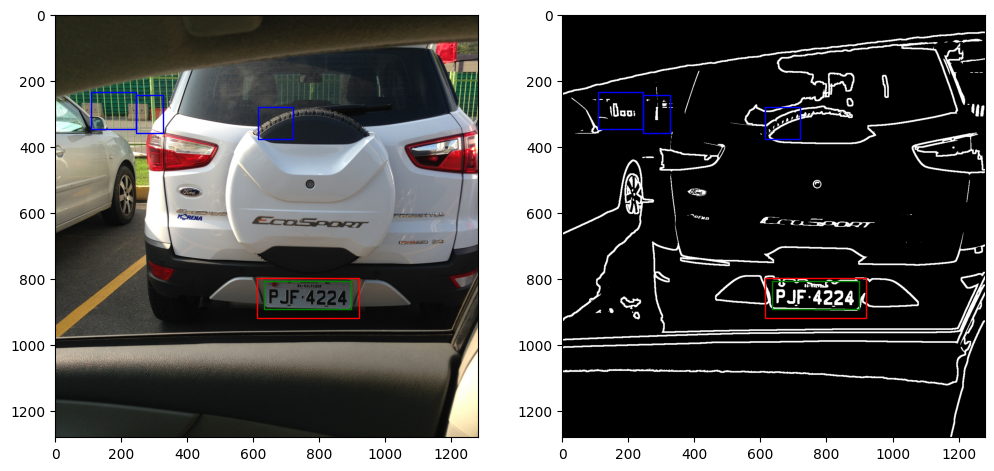

In [13]:
show_detection(baseline_detector, ds, 100, cmap_processed='gray')

### Exemplo "Médio"

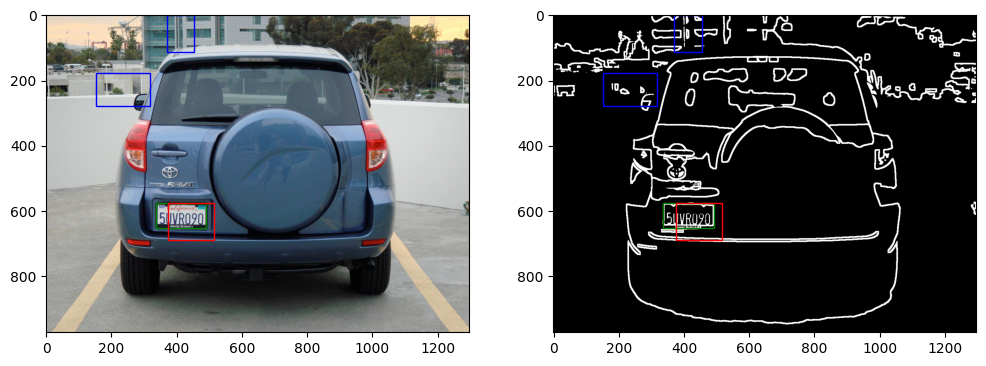

In [14]:
show_detection(baseline_detector, ds, 130, cmap_processed='gray')

### Exemplo "Ruim"

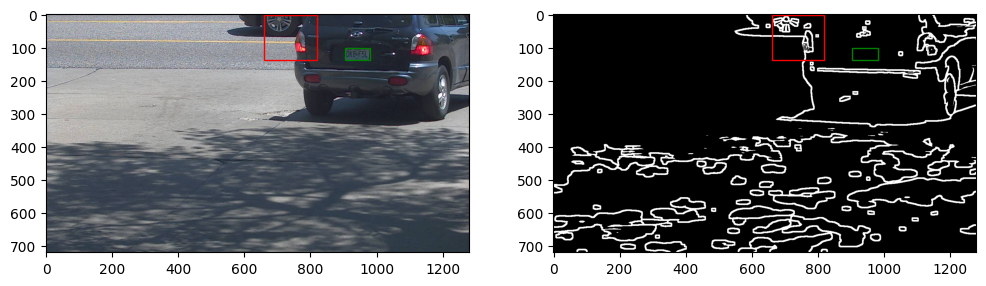

In [18]:
show_detection(baseline_detector, ds, 430, cmap_processed='gray')

## Otimização de Parâmetros: realizando a tunagem dos detectores

Para validar se existem combinações que produzem melhores resultados do que os baselines apresentados, vamos utilizar algoritmos de otimização de hiperparâmetros com o intuito de gerar automaticamente combinações de pré-processamento, parâmetros e afins.

## Tabela Comparativa dos Melhores Resultados

Considerando todos os experimentos, a tabela abaixo contém algumas métricas de avaliação.